# Exercise: 311 Requests

#### Summary

In NYC, you can call 311 with *anything* about the city - questions, complaints, etc. We'll be analyzing requests from 2015-2016 from the Department of Transportation and NYPD.

#### Data Source(s)

Filtered from full set, https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

#### Files

- `311-requests/311_Service_Requests_from_2010_to_Present.csv`, about 1.8 million rows (over 1GB of data)

#### Data dictionary

Visit [this page](https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9#schema-preview) and click 'Show more' on the bottom right of the list (53 columns).

#### Skills

- Opening large files
- Time

## Opening the file

It's a big one! If your computer is slow or you only have 2GB of RAM, you might want to specify `nrows=50000` (or less). Increase the number until it takes around 20 seconds, maybe!

In [1]:
import pandas as pd
import numpy
import datetime as datetime
%matplotlib inline


### Measuring time in Jupyter Notebooks

How long did that take? Read it in again, but this time **time how long it takes.** (and no, not with your watch - with Jupyter!)

In [9]:
%%time
df = pd.read_csv("data/311_Service_Requests_from_2010_to_Present.csv", nrows=10000)

CPU times: user 190 ms, sys: 28.4 ms, total: 219 ms
Wall time: 259 ms


### Look at the first few rows

Make sure you can see **every single column.**

In [10]:
pd.set_option("display.max_columns", 100)

In [11]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,31463990,09/04/2015 10:55:25 PM,09/05/2015 02:06:54 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10460.0,1110 WYATT STREET,WYATT STREET,DEVOE AVENUE,BRONX PARK AVENUE,NaN,NaN,ADDRESS,BRONX,NaN,Precinct,Closed,09/05/2015 06:55:25 AM,The Police Department responded and upon arriv...,09/05/2015 02:06:54 AM,06 BRONX,BRONX,1018201.0,245083.0,Unspecified,BRONX,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.839306,-73.877301,"(40.83930620730105, -73.8773009180668)"
1,31463991,09/04/2015 01:53:45 PM,09/04/2015 06:37:24 PM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10031.0,NaN,NaN,NaN,NaN,WEST 151 STREET,BROADWAY,INTERSECTION,NEW YORK,NaN,Precinct,Closed,09/04/2015 09:53:45 PM,The Police Department responded to the complai...,09/04/2015 06:37:24 PM,09 MANHATTAN,MANHATTAN,998728.0,241754.0,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.830222,-73.947684,"(40.830222460372724, -73.94768359377827)"
2,31463992,09/04/2015 09:15:43 PM,09/04/2015 10:32:01 PM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10031.0,545 WEST 144 STREET,WEST 144 STREET,AMSTERDAM AVENUE,BROADWAY,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,09/05/2015 05:15:43 AM,The Police Department responded to the complai...,09/04/2015 10:32:02 PM,09 MANHATTAN,MANHATTAN,998263.0,239889.0,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.825104,-73.949368,"(40.825104318551325, -73.94936777115372)"
3,31463993,09/05/2015 01:06:57 AM,09/05/2015 02:26:43 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,11203.0,UTICA AVENUE,UTICA AVENUE,AVENUE D,FOSTER AVENUE,NaN,NaN,BLOCKFACE,BROOKLYN,NaN,Precinct,Closed,09/05/2015 09:06:57 AM,The Police Department responded to the complai...,09/05/2015 02:26:44 AM,17 BROOKLYN,BROOKLYN,1003890.0,172805.0,Unspecified,BROOKLYN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.640965,-73.929232,"(40.64096464471428, -73.92923194083798)"
4,31463995,09/04/2015 07:48:25 AM,09/04/2015 05:21:18 PM,NYPD,New York City Police Department,Illegal Parking,Overnight Commercial Storage,Street/Sidewalk,11210.0,GLENWOOD ROAD,GLENWOOD ROAD,BROOKLYN AVENUE,EAST 37 STREET,NaN,NaN,BLOCKFACE,BROOKLYN,NaN,Precinct,Closed,09/04/2015 03:48:25 PM,The Police Department responded to the complai...,09/04/2015 05:21:19 PM,17 BROOKLYN,BROOKLYN,1000480.0,170405.0,Unspecified,BROOKLYN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.634384,-73.941525,"(40.63438406330588, -73.9415248319131)"


### Speeding things up

We're going to be looking at open and close times, agencies, and the complaints (both types and descriptor). The only kind of location-based thing we'll want is borough.

**How much faster is it if we only read in those columns?**

In [12]:
%%time
df = pd.read_csv("data/311_Service_Requests_from_2010_to_Present.csv", usecols=['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Complaint Type', 'Descriptor', 'Location Type', 'Borough'])
df.head()

CPU times: user 16.9 s, sys: 1.2 s, total: 18.1 s
Wall time: 19.4 s


## Converting the 'Created Date' and 'Closed Date' columns to datetimes

### First, testing some things out

Let's take a look at converting **Created Date**, but **not all at once**.

1. Take 10,000 of them and try to convert them **without** a format string. Time it.
2. Take the same 10,000 and try to convert them **with** a format string. Time it.

If you tried to do all 1.8 million rows, **how long might it take with a format string vs without?**

In [8]:
%%time
first_ten_thousand = df['Created Date'].head(10000)
pd.to_datetime(first_ten_thousand)

CPU times: user 4.68 s, sys: 24.9 ms, total: 4.71 s
Wall time: 4.97 s


In [13]:
%%time
pd.to_datetime(first_ten_thousand, format = "%m/%d/%Y %H:%M:%S %p")

CPU times: user 91.7 ms, sys: 912 µs, total: 92.6 ms
Wall time: 102 ms


0      2015-09-04 10:55:25
1      2015-09-04 01:53:45
2      2015-09-04 09:15:43
3      2015-09-05 01:06:57
4      2015-09-04 07:48:25
5      2015-09-04 11:31:12
6      2015-09-04 07:02:24
7      2015-09-04 12:34:05
8      2015-09-04 07:56:42
9      2015-09-04 09:04:42
10     2015-09-04 08:26:09
11     2015-09-04 11:07:15
12     2015-09-04 10:23:59
13     2015-09-04 11:16:12
14     2015-09-04 04:49:55
15     2015-09-04 02:39:46
16     2015-09-04 08:21:22
17     2015-09-04 11:34:23
18     2015-09-04 09:55:19
19     2015-09-04 11:44:07
20     2015-09-04 08:12:10
21     2015-09-04 11:14:40
22     2015-09-04 08:17:20
23     2015-09-04 10:54:59
24     2015-09-04 03:45:14
25     2015-09-04 11:48:20
26     2015-09-05 01:53:40
27     2015-09-04 11:34:47
28     2015-09-04 11:37:52
29     2015-09-04 11:01:37
               ...        
9970   2015-09-07 01:39:12
9971   2015-09-07 06:53:28
9972   2015-09-07 06:10:00
9973   2015-09-07 04:02:27
9974   2015-09-07 09:00:33
9975   2015-09-07 07:13:20
9

### Creating new columns

Create new columns called `created_at` and `closed_at` from the `Created Date` and `Closed Date` columns. Do them individually, and **time them**.

In [14]:
%%time
df['created_at'] = pd.to_datetime(df['Created Date'], format="%m/%d/%Y %H:%M:%S %p")


CPU times: user 17.4 s, sys: 101 ms, total: 17.5 s
Wall time: 17.9 s


In [15]:
df['created_at'].head()

0   2015-09-04 10:55:25
1   2015-09-04 01:53:45
2   2015-09-04 09:15:43
3   2015-09-05 01:06:57
4   2015-09-04 07:48:25
Name: created_at, dtype: datetime64[ns]

In [16]:
%%time
df['closed_at'] = pd.to_datetime(df['Closed Date'], format="%m/%d/%Y %H:%M:%S %p")


CPU times: user 17.1 s, sys: 102 ms, total: 17.2 s
Wall time: 17.6 s


In [17]:
df['closed_at'].head()

0   2015-09-05 02:06:54
1   2015-09-04 06:37:24
2   2015-09-04 10:32:01
3   2015-09-05 02:26:43
4   2015-09-04 05:21:18
Name: closed_at, dtype: datetime64[ns]

### Confirming they look okay

Take a look at the first few rows to make sure the dates look correct, and then make sure their data type is `datetime64[ns]`.

In [18]:
df.dtypes

Unique Key                 int64
Created Date              object
Closed Date               object
Agency                    object
Complaint Type            object
Descriptor                object
Location Type             object
Borough                   object
created_at        datetime64[ns]
closed_at         datetime64[ns]
dtype: object

# Examining agencies

Who has more 311 requests, the Department of Transportation or the NYPD?

In [41]:
df['Agency'].value_counts()

NYPD    1251121
DOT      593157
Name: Agency, dtype: int64

## What's the difference between "Complaint Type" and "Descriptor" columns?

In [ ]:
# complaint type is the type of problem, descriptor is the source or cause of the problem

## What are the most popular categories of complaints for the NYPD? For the DOT?

In [19]:
df[df['Agency'] == 'NYPD']['Complaint Type'].value_counts().head(1)

Noise - Residential    429932
Name: Complaint Type, dtype: int64

In [20]:
df[df['Agency'] == 'DOT']['Complaint Type'].value_counts().head(1)

Street Condition    215052
Name: Complaint Type, dtype: int64

## When people are complaining about street conditions, what are they usually complaining about?

In [21]:
df[df['Complaint Type'] =='Street Condition']['Descriptor'].value_counts().head(1)

Pothole    137931
Name: Descriptor, dtype: int64

## What kinds of noise are they complaining about when making residential noise complaints?

In [47]:
df[df['Complaint Type'] == 'Noise - Residential']['Descriptor'].value_counts()

Loud Music/Party    283631
Banging/Pounding    108470
Loud Talking         30097
Loud Television       7734
Name: Descriptor, dtype: int64

# Timing our complaints

How many complaints were filed each month?

- Tip: You'll probably want to `.set_index` first!

In [22]:
df.set_index('created_at', inplace=True)
df

,Unique Key,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Borough,closed_at
created_at,,,,,,,,,
2015-09-04 10:55:25,31463990,09/04/2015 10:55:25 PM,09/05/2015 02:06:54 AM,NYPD,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,BRONX,2015-09-05 02:06:54
2015-09-04 01:53:45,31463991,09/04/2015 01:53:45 PM,09/04/2015 06:37:24 PM,NYPD,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,MANHATTAN,2015-09-04 06:37:24
2015-09-04 09:15:43,31463992,09/04/2015 09:15:43 PM,09/04/2015 10:32:01 PM,NYPD,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,MANHATTAN,2015-09-04 10:32:01
2015-09-05 01:06:57,31463993,09/05/2015 01:06:57 AM,09/05/2015 02:26:43 AM,NYPD,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,BROOKLYN,2015-09-05 02:26:43
2015-09-04 07:48:25,31463995,09/04/2015 07:48:25 AM,09/04/2015 05:21:18 PM,NYPD,Illegal Parking,Overnight Commercial Storage,Street/Sidewalk,BROOKLYN,2015-09-04 05:21:18
2015-09-04 11:31:12,31463996,09/04/2015 11:31:12 AM,09/04/2015 03:01:54 PM,NYPD,Illegal Parking,Overnight Commercial Storage,Street/Sidewalk,BROOKLYN,2015-09-04 03:01:54
2015-09-04 07:02:24,31463997,09/04/2015 07:02:24 AM,09/04/2015 01:55:53 PM,NYPD,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,BROOKLYN,2015-09-04 01:55:53
2015-09-04 12:34:05,31463998,09/04/2015 12:34:05 PM,09/04/2015 01:38:47 PM,NYPD,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,MANHATTAN,2015-09-04 01:38:47
2015-09-04 07:56:42,31463999,09/04/2015 07:56:42 PM,09/04/2015 09:18:31 PM,NYPD,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,STATEN ISLAND,2015-09-04 09:18:31


## Plot how many requests were filed each month

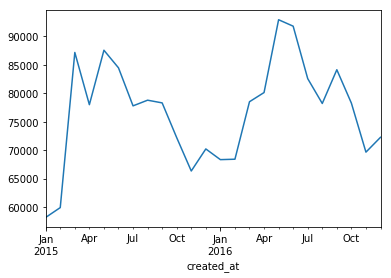

In [24]:
df['Unique Key'].resample('M').count().plot()

# Hmmm, it looks like a cycle

What could cause that? Try a couple comparisons to see if you can find out.

- Tip: Maybe the most popular summer complaints vs winter
- Tip: Maybe graphing the different agencies on the same graph

If you don't figure it out **that's okay!** 

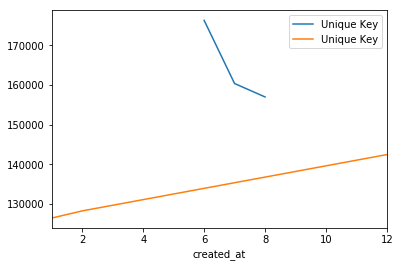

In [25]:
summer_df = df[df.index.month.isin([6, 7, 8])]
winter_df = df[df.index.month.isin([12, 1, 2])]
ax = summer_df.groupby(summer_df.index.month).count().plot(y='Unique Key')
winter_df.groupby(winter_df.index.month).count().plot(y='Unique Key', ax=ax)

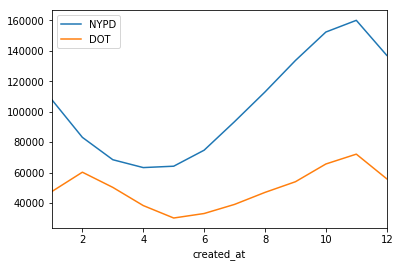

In [26]:
NYPD_df = df[df['Agency'] == 'NYPD']
DOT_df = df[df['Agency'] == 'DOT']

ax = NYPD_df.groupby(by=NYPD_df.index.hour).count().plot(y='Unique Key', label='NYPD')
DOT_df.groupby(by=DOT_df.index.hour).count().plot(y='Unique Key', label='DOT', ax=ax)

## Time of day

### What time of day do people complain?

In [27]:
df['Unique Key'].groupby(by=df.index.hour).count().sort_values(ascending=False).head()

created_at
11    232162
10    218008
12    192942
9     187637
8     159947
Name: Unique Key, dtype: int64

In [ ]:
# most people complain at 11pm. 

### What time of day do people complain about potholes?

In [118]:
potholes_df = df[df['Descriptor'] == 'Pothole']
potholes_df.head()

,Unique Key,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Borough,closed_at
created_at,,,,,,,,,
2015-09-04 08:54:15,31464047,09/04/2015 08:54:15 AM,09/08/2015 11:10:00 AM,DOT,Street Condition,Pothole,NaN,STATEN ISLAND,2015-09-08 11:10:00
2015-09-04 11:42:34,31464106,09/04/2015 11:42:34 AM,09/09/2015 03:44:00 PM,DOT,Street Condition,Pothole,NaN,BROOKLYN,2015-09-09 15:44:00
2015-09-04 18:01:07,31464115,09/04/2015 06:01:07 PM,09/14/2015 02:34:00 PM,DOT,Street Condition,Pothole,NaN,BROOKLYN,2015-09-14 14:34:00
2015-09-03 14:53:15,31464116,09/03/2015 02:53:15 PM,09/09/2015 03:43:00 PM,DOT,Street Condition,Pothole,NaN,BROOKLYN,2015-09-09 15:43:00
2015-09-04 15:03:16,31464157,09/04/2015 03:03:16 PM,09/14/2015 01:30:00 PM,DOT,Street Condition,Pothole,NaN,BRONX,2015-09-14 13:30:00


In [121]:
potholes_df['Unique Key'].groupby(by=potholes_df.index.hour).count().sort_values(ascending=False).head()

created_at
14    14643
15    11432
13    10375
7      9876
9      9624
Name: Unique Key, dtype: int64

In [122]:
# most people complain about potholes at 2pm. 

### What time of day do people complain about loud parties?

In [123]:
party_df = df[df['Descriptor'] == 'Loud Music/Party']
party_df['Unique Key'].groupby(by=party_df.index.hour).count().sort_values(ascending=False).head()

created_at
23    63615
22    54473
0     53682
1     39022
21    36233
Name: Unique Key, dtype: int64

In [124]:
# most people complain about loud parties at 11pm. 

## Days of the week

### What days of the week do people complain about potholes?

In [133]:
potholes_df['Unique Key'].groupby(by=potholes_df.index.dayofweek).count().sort_values(ascending=False)

created_at
1    25260
2    23842
3    23702
0    22682
4    17483
6    14399
5    10766
Name: Unique Key, dtype: int64

In [ ]:
# The day of the week that most people complain about potholes is Tuesdays. 
# Documentation: DatetimeIndex.dayofweek / The day of the week with Monday=0, Sunday=6

### What days of the week do people complain about loud parties?

In [135]:
party_df['Unique Key'].groupby(by=party_df.index.dayofweek).count().sort_values(ascending=False)

created_at
6    118467
5    118369
4     58276
0     38864
3     37053
2     31736
1     29823
Name: Unique Key, dtype: int64

In [ ]:
# The day of the week that most people complain about potholes is Sunday (actually Saturday night!). 
# Documentation: DatetimeIndex.dayofweek / The day of the week with Monday=0, Sunday=6

### What do you think is the best kind of graph for describing day of the week complaints?

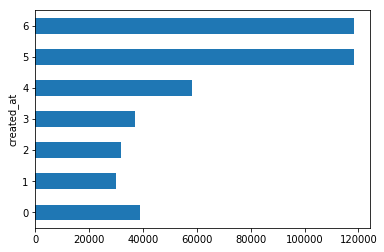

In [146]:
party_df['Unique Key'].groupby(by=party_df.index.dayofweek).count().plot(kind='barh')

# Some more investigation

## Are there more homeless people in the city in the summer or in the winter?

In [158]:
df[df['Complaint Type'] == 'Homeless Encampment'].head()

,Unique Key,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Borough,closed_at
created_at,,,,,,,,,
2015-09-05 01:34:22,31464059,09/05/2015 01:34:22 AM,09/05/2015 04:03:50 AM,NYPD,Homeless Encampment,NaN,Store/Commercial,MANHATTAN,2015-09-05 04:03:50
2015-09-04 11:38:17,31464113,09/04/2015 11:38:17 AM,09/04/2015 12:21:14 PM,NYPD,Homeless Encampment,NaN,Street/Sidewalk,BROOKLYN,2015-09-04 12:21:14
2015-09-04 14:40:39,31464642,09/04/2015 02:40:39 PM,09/04/2015 07:36:01 PM,NYPD,Homeless Encampment,NaN,Park/Playground,BROOKLYN,2015-09-04 19:36:01
2015-09-04 15:21:22,31464696,09/04/2015 03:21:22 PM,09/04/2015 04:03:18 PM,NYPD,Homeless Encampment,NaN,Street/Sidewalk,BROOKLYN,2015-09-04 16:03:18
2015-09-04 09:22:50,31464699,09/04/2015 09:22:50 AM,09/04/2015 10:28:03 AM,NYPD,Homeless Encampment,NaN,Street/Sidewalk,MANHATTAN,2015-09-04 10:28:03


In [156]:
summer_df[summer_df['Complaint Type'] == 'Homeless Encampment']['Unique Key'].count()

3663

In [157]:
winter_df[winter_df['Complaint Type'] == 'Homeless Encampment']['Unique Key'].count()

1298

In [ ]:
# there are more complains about homeless poeple in the summer than in the winter.

## What holiday(s) are most popular for illegal fireworks?

In [163]:
fireworks_df = df[df['Complaint Type'] == 'Illegal Fireworks']
fireworks_df['Unique Key'].groupby(by=fireworks_df.index.date).count().sort_values(ascending=False).head(10)

2015-07-04    24
2016-07-03    20
2016-07-04    20
2015-07-05    17
2015-07-03    14
2016-07-06    13
2016-07-05    12
2016-06-26    10
2016-07-02     9
2015-06-29     7
Name: Unique Key, dtype: int64

In [ ]:
# 4th of July

## Plot all kinds of noise complaints on top of each other

In [172]:
noise_df = df[df['Complaint Type'].str.contains("Noise")]
noise_df['Complaint Type'].value_counts()

Noise - Residential         429932
Noise - Street/Sidewalk     112890
Noise - Commercial           93115
Noise - Vehicle              43213
Noise - Park                  7995
Noise - House of Worship      1991
Name: Complaint Type, dtype: int64

In [205]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

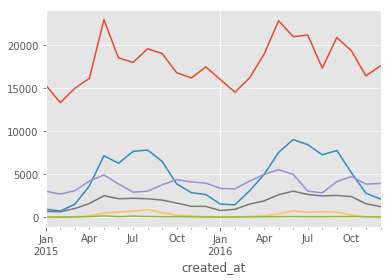

In [218]:
noise_res_df = df[df['Complaint Type'] == 'Noise - Residential']
noise_str_df = df[df['Complaint Type'] == 'Noise - Street/Sidewalk']
noise_com_df = df[df['Complaint Type'] == 'Noise - Commercial']
noise_veh_df = df[df['Complaint Type'] == 'Noise - Vehicle']
noise_par_df = df[df['Complaint Type'] == 'Noise - Park']
noise_how_df = df[df['Complaint Type'] == 'Noise - House of Worship']

ax = noise_res_df['Unique Key'].resample('M').count().plot()
noise_str_df['Unique Key'].resample('M').count().plot(ax=ax)
noise_com_df['Unique Key'].resample('M').count().plot(ax=ax)
noise_veh_df['Unique Key'].resample('M').count().plot(ax=ax)
noise_par_df['Unique Key'].resample('M').count().plot(ax=ax)
noise_how_df['Unique Key'].resample('M').count().plot(ax=ax)